# Transfer Learning - Comparing losses and accuracies for different standard algorithms, Confusion Matrix and Classification Report.

**Output:** Post running the below script, output resembles as shown in the below image.

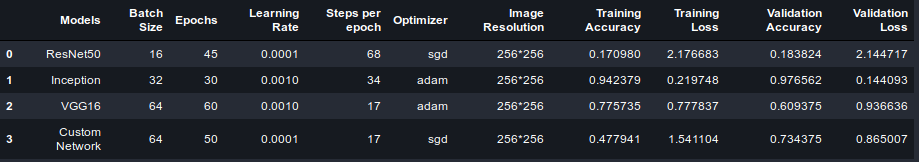

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import shutil   
from keras import backend as K
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import History 
from sklearn.metrics import classification_report, confusion_matrix
import keras
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = '../input/tomato-diseases-label-dataset/tomato diseases label dataset/training/training'
val = '../input/tomato-diseases-label-dataset/tomato diseases label dataset/validation/validation'
labels = pd.read_csv("../input/tomato-diseases-label-dataset/tomato diseases label dataset/tomato_labels.txt")
labels

,Label\t,Latin Name \t\t\t\t\t,Common Name\t\t\t\t,Train Images\t,Validation Images
0,n0 \t,Tomato___Bacterial_spot\t\t\t,Tomato___Bacterial_spot\t\t,1702,425
1,n1 \t,Tomato___Early_blight\t\t\t\t,Tomato___Early_blight\t\t\t,1920,480
2,n2 \t,Tomato___healthy\t\t\t\t,Tomato___healthy\t\t\t,1926,481
3,n3\t,Tomato___Late_blight\t\t\t\t,Tomato___Late_blight\t\t\t,1851,463
4,n4 \t,Tomato___Leaf_Mold\t\t\t\t,Tomato___Leaf_Mold\t\t\t,1882,470
5,n5 \t,Tomato___Septoria_leaf_spot\t\t\t,Tomato___Septoria_leaf_spot\t\t,1745,436
6,n6\t,Tomato___Spider_mites Two-spotted_spider_mite\t,Tomato___Spider_mites Two-spotted_spider_mite\t,1741,435
7,n7\t,Tomato___Target_Spot\t\t\t\t,Tomato___Target_Spot\t\t\t,1827,457
8,n8\t,Tomato___Tomato_mosaic_virus\t\t\t,Tomato___Tomato_mosaic_virus\t\t,1790,448
9,n9\t,Tomato___Tomato_Yellow_Leaf_Curl_Virus\t\t,Tomato___Tomato_Yellow_Leaf_Curl_Virus\t,1961,490


In [3]:
# Total number of training images
num_of_train_samples = 0
for train_dataset in os.listdir(train):
    in_folder = train + "/" + train_dataset 
    in_folder_list = os.listdir(in_folder)
    num_of_train_samples = num_of_train_samples + len(in_folder_list)
print("Number of Training samples   : ",num_of_train_samples)

# Total number of validation images
num_of_validation_samples = 0
for validation_dataset in os.listdir(val):
    in_folder_val = val + "/" + validation_dataset
    in_folder_val_list = os.listdir(in_folder_val)
    num_of_validation_samples = num_of_validation_samples + len(in_folder_val_list)
print("Number of Validation samples : ", num_of_validation_samples)

Number of Training samples   :  18345
Number of Validation samples :  4585


# Image Generator:¶

Real time data augmentation, the data will be looped over (in batches)

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)

defining hyperparameters, image resolution and other stuffs...

In [5]:
batch_size = 64
learning_rate = 0.0010
epoch = 20

# Defining image width and height respectively
img_rows = 256
img_cols = 256

train_generator = train_datagen.flow_from_directory(train,
                                                    target_size = (img_rows, img_cols),
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical')

validation_generator = val_datagen.flow_from_directory(val,
                                                        target_size = (img_rows, img_cols),
                                                        batch_size = batch_size,
                                                        shuffle = False, class_mode='categorical')

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


class_mode = 'binary' (2 output classes) ---- if more class prefer class_mode = 'categorical'.

Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch

# ResNet 50

In [6]:
steps_per_epoch = num_of_train_samples // batch_size
print("Steps per epoch: ",steps_per_epoch)

Steps per epoch:  286


In [7]:
from keras.applications import ResNet50
# The sequential API allows you to create models layer-by-layer
resnet_model = Sequential()
resnet_model.add(ResNet50(include_top=False, 
                   pooling='max', 
                   weights='imagenet'))
resnet_model.add(Dense(10, activation="softmax"))

# Summary: to find the number of parameters
resnet_model.layers[0].trainable=False
resnet_model.summary()

adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
resnet_model.compile(loss="categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])


94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
# Trains the model for a given number of epochs (iterations on a dataset).
resnet_training = resnet_model.fit_generator(train_generator,
                               steps_per_epoch = steps_per_epoch,
                               epochs = epoch,
                               validation_data = validation_generator,
                               validation_steps = num_of_validation_samples // batch_size)


Epoch 1/20
286/286 [==============================] - 417s 1s/step - loss: 2.1890 - accuracy: 0.1985 - val_loss: 1.9335 - val_accuracy: 0.3250
Epoch 2/20
286/286 [==============================] - 318s 1s/step - loss: 1.9542 - accuracy: 0.2869 - val_loss: 1.8087 - val_accuracy: 0.3759
Epoch 3/20
286/286 [==============================] - 314s 1s/step - loss: 1.8618 - accuracy: 0.3252 - val_loss: 1.8909 - val_accuracy: 0.3521
Epoch 4/20
286/286 [==============================] - 310s 1s/step - loss: 1.8039 - accuracy: 0.3464 - val_loss: 1.9001 - val_accuracy: 0.3512
Epoch 5/20
286/286 [==============================] - 312s 1s/step - loss: 1.7497 - accuracy: 0.3693 - val_loss: 1.7163 - val_accuracy: 0.4188
Epoch 6/20
286/286 [==============================] - 311s 1s/step - loss: 1.7251 - accuracy: 0.3757 - val_loss: 1.8725 - val_accuracy: 0.3151
Epoch 7/20
286/286 [==============================] - 314s 1s/step - loss: 1.6931 - accuracy: 0.3991 - val_loss: 1.8060 - val_accuracy: 0.3966

Saving the model history for ResNet - 50

In [9]:
training_accuracy_resnet      = resnet_training.history['accuracy'][-1]
training_loss_resnet          = resnet_training.history['loss'][-1]
validation_accuracy_resnet    = resnet_training.history['val_accuracy'][-1]
validation_loss_resnet        = resnet_training.history['val_loss'][-1]
print("Training Accuracy ResNet   :", training_accuracy_resnet )
print("Training Loss ResNet       :", training_loss_resnet)
print("Validation Accuracy ResNet :", validation_accuracy_resnet)
print("Validation Loss ResNet     :", validation_loss_resnet)

Training Accuracy ResNet   : 0.4547891318798065
Training Loss ResNet       : 1.5295135974884033
Validation Accuracy ResNet : 0.41241195797920227
Validation Loss ResNet     : 1.8325248956680298


Generating Confusion Matrix and Classification Report for ResNet 50

In [10]:
# Generating Confusion Matrix and Classification Report
Y_pred_res = resnet_model.predict_generator(validation_generator, num_of_validation_samples // batch_size+1)
y_pred_res = np.argmax(Y_pred_res, axis=1)
print('Confusion Matrix')
conf_matrix_res = confusion_matrix(validation_generator.classes, y_pred_res)
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)
print("=============================================================================================")
print('Classification Report')
target_names = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9']
class_rep_res = classification_report(validation_generator.classes, y_pred_res, target_names=target_names)
print(class_rep_res)

Confusion Matrix
[[332   5  48   2  19   0   8   2   7   2]
 [ 48  77  65   1 113   5  54  52  55  10]
 [  8   0 467   0   1   0   0   1   4   0]
 [ 48  12  72  25 113   6  63  51  68   5]
 [ 40   9  88   0 190   7  39  19  77   1]
 [ 51   1 188   1  40  32  20  26  74   3]
 [  1   0 202   1   6   0 201  11  13   0]
 [  4   1 286   0   2   0  87  55  22   0]
 [  0   0  72   0   7   0  67   4 298   0]
 [ 79   1  13   0  35   1  80   2  63 216]]
Classification Report
              precision    recall  f1-score   support

          n0       0.54      0.78      0.64       425
          n1       0.73      0.16      0.26       480
          n2       0.31      0.97      0.47       481
          n3       0.83      0.05      0.10       463
          n4       0.36      0.40      0.38       470
          n5       0.63      0.07      0.13       436
          n6       0.32      0.46      0.38       435
          n7       0.25      0.12      0.16       457
          n8       0.44      0.67      0.53

# Inception

In [11]:
epoch_inc = 20
learning_rate_inc = 0.001
batch_size_inc = 64
steps_per_epoch_inc = num_of_train_samples // batch_size_inc
print("Steps per epoch: ",steps_per_epoch_inc)

Steps per epoch:  286


In [12]:
from keras.applications import InceptionV3
# The sequential API allows us to create model layer by layer
inc_model = Sequential()
inc_model.add(InceptionV3(include_top=False, 
                      pooling='max',
                      weights='imagenet'))
inc_model.add(Dense(10, activation="softmax"))

# Summary: to find the number of parameters
inc_model.layers[0].trainable=False
inc_model.summary()

adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
inc_model.compile(loss="categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])

87916544/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
# Trains the model for a given number of epochs (iterations on a dataset).
inc_training = inc_model.fit_generator(train_generator,
                                       steps_per_epoch = steps_per_epoch_inc,
                                       epochs = epoch_inc,
                                       validation_data = validation_generator,
                                       validation_steps = num_of_validation_samples // batch_size_inc)

Epoch 1/20
286/286 [==============================] - 318s 1s/step - loss: 1.5836 - accuracy: 0.5035 - val_loss: 1.1344 - val_accuracy: 0.6120
Epoch 2/20
286/286 [==============================] - 319s 1s/step - loss: 0.9694 - accuracy: 0.6748 - val_loss: 0.8625 - val_accuracy: 0.6978
Epoch 3/20
286/286 [==============================] - 318s 1s/step - loss: 0.8474 - accuracy: 0.7143 - val_loss: 0.8704 - val_accuracy: 0.7005
Epoch 4/20
286/286 [==============================] - 317s 1s/step - loss: 0.7671 - accuracy: 0.7419 - val_loss: 0.7675 - val_accuracy: 0.7346
Epoch 5/20
286/286 [==============================] - 319s 1s/step - loss: 0.7249 - accuracy: 0.7512 - val_loss: 0.6817 - val_accuracy: 0.7639
Epoch 6/20
286/286 [==============================] - 319s 1s/step - loss: 0.6928 - accuracy: 0.7670 - val_loss: 0.7399 - val_accuracy: 0.7476
Epoch 7/20
286/286 [==============================] - 320s 1s/step - loss: 0.6651 - accuracy: 0.7771 - val_loss: 0.6294 - val_accuracy: 0.7806

Saving the model history for Inception

In [14]:
training_accuracy_inc      = inc_training.history['accuracy'][-1]
training_loss_inc          = inc_training.history['loss'][-1]
validation_accuracy_inc    = inc_training.history['val_accuracy'][-1]
validation_loss_inc        = inc_training.history['val_loss'][-1]
print("Training Accuracy Inception   :", training_accuracy_inc )
print("Training Loss Inception       :", training_loss_inc)
print("Validation Accuracy Inception :", validation_accuracy_inc)
print("Validation Loss Inception     :", validation_loss_inc)

Training Accuracy Inception   : 0.8123188018798828
Training Loss Inception       : 0.570759117603302
Validation Accuracy Inception : 0.8091989159584045
Validation Loss Inception     : 0.5642490386962891


Generating Confusion Matrix and Classification Report for Inception

In [15]:
# Generating Confusion Matrix and Classification Report
Y_pred_inc = inc_model.predict_generator(validation_generator, num_of_validation_samples // batch_size+1)
y_pred_inc = np.argmax(Y_pred_inc, axis=1)
print('Confusion Matrix')
conf_matrix_inc = confusion_matrix(validation_generator.classes, y_pred_inc)
cm_inc = np.array2string(conf_matrix_inc)
print(conf_matrix_inc)
print("=============================================================================================")
print('Classification Report')
# target_names = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9']
class_rep_inc = classification_report(validation_generator.classes, y_pred_inc, target_names=target_names)
print(class_rep_inc)

Confusion Matrix
[[375   1   3   2   1  26   2   9   2   4]
 [ 19 291   3  54   6  52  22  26   5   2]
 [  0   0 441   9   0   2  11  17   1   0]
 [  1   3   6 425   3   5   3  12   2   3]
 [  6  11   8  47 306  22  19   9  37   5]
 [ 14   8   6  22   2 347   5  24   7   1]
 [  6   2  12  10   3   7 348  35   5   7]
 [ 17   8  37  24   0  22  32 313   1   3]
 [  0   2   3   9   5   6   7   2 412   2]
 [  9   1   0   3   1   3   9   1   4 459]]
Classification Report
              precision    recall  f1-score   support

          n0       0.84      0.88      0.86       425
          n1       0.89      0.61      0.72       480
          n2       0.85      0.92      0.88       481
          n3       0.70      0.92      0.80       463
          n4       0.94      0.65      0.77       470
          n5       0.71      0.80      0.75       436
          n6       0.76      0.80      0.78       435
          n7       0.70      0.68      0.69       457
          n8       0.87      0.92      0.89

# VGG16

In [16]:
epoch_vgg = 20
learning_rate_vgg = 0.001
batch_size_vgg = 64
steps_per_epoch_vgg = num_of_train_samples // batch_size_vgg
print("Steps per epoch: ",steps_per_epoch_vgg)

Steps per epoch:  286


In [17]:
from keras.applications import vgg16
    # The sequential API allows you to create models layer-by-layer
vgg_model=Sequential()
vgg_model.add(vgg16.VGG16(include_top = False, pooling = 'max', weights = 'imagenet'))
vgg_model.add(Dense(10, activation="softmax"))

    # Summary: to find the number of parameters
vgg_model.layers[0].trainable=False
vgg_model.summary() 

adam = optimizers.Adam(lr=learning_rate_vgg, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
vgg_model.compile(loss="categorical_crossentropy",
                  optimizer=adam,
                  metrics=["accuracy"])

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
# Trains the model for a given number of epochs (iterations on a dataset).
vgg_training = vgg_model.fit_generator(train_generator,
                                       steps_per_epoch = steps_per_epoch_vgg,
                                       epochs = epoch_vgg,
                                       validation_data = validation_generator,
                                       validation_steps = num_of_validation_samples // batch_size_vgg)

Epoch 1/20
286/286 [==============================] - 346s 1s/step - loss: 1.7445 - accuracy: 0.4256 - val_loss: 1.3998 - val_accuracy: 0.5511
Epoch 2/20
286/286 [==============================] - 342s 1s/step - loss: 1.2203 - accuracy: 0.6168 - val_loss: 1.1334 - val_accuracy: 0.6360
Epoch 3/20
286/286 [==============================] - 342s 1s/step - loss: 1.0569 - accuracy: 0.6680 - val_loss: 1.0177 - val_accuracy: 0.6721
Epoch 4/20
286/286 [==============================] - 345s 1s/step - loss: 0.9605 - accuracy: 0.6944 - val_loss: 0.9423 - val_accuracy: 0.6948
Epoch 5/20
286/286 [==============================] - 343s 1s/step - loss: 0.8978 - accuracy: 0.7130 - val_loss: 0.9017 - val_accuracy: 0.7044
Epoch 6/20
286/286 [==============================] - 341s 1s/step - loss: 0.8502 - accuracy: 0.7269 - val_loss: 0.8512 - val_accuracy: 0.7262
Epoch 7/20
286/286 [==============================] - 343s 1s/step - loss: 0.8138 - accuracy: 0.7366 - val_loss: 0.8042 - val_accuracy: 0.7372

Saving the model history for VGG

In [19]:
training_accuracy_vgg      = vgg_training.history['accuracy'][-1]
training_loss_vgg          = vgg_training.history['loss'][-1]
validation_accuracy_vgg    = vgg_training.history['val_accuracy'][-1]
validation_loss_vgg        = vgg_training.history['val_loss'][-1]
print("Training Accuracy VGG    :", training_accuracy_vgg )
print("Training Loss VGG        :", training_loss_vgg)
print("Validation Accuracy VGG  :", validation_accuracy_vgg)
print("Validation Loss VGG      :", validation_loss_vgg)

Training Accuracy VGG    : 0.7796619534492493
Training Loss VGG        : 0.664605438709259
Validation Accuracy VGG  : 0.7704665660858154
Validation Loss VGG      : 0.6637090444564819


Generating Confusion Matrix and Classification Report for VGG

In [20]:
# Generating Confusion Matrix and Classification Report
Y_pred_vgg = vgg_model.predict_generator(validation_generator, num_of_validation_samples // batch_size+1)
y_pred_vgg = np.argmax(Y_pred_vgg, axis=1)
print('Confusion Matrix')
conf_matrix_vgg = confusion_matrix(validation_generator.classes, y_pred_vgg)
cm_vgg = np.array2string(conf_matrix_vgg)
print(conf_matrix_vgg)
print("=============================================================================================")
print('Classification Report')
target_names = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9']
class_rep_vgg = classification_report(validation_generator.classes, y_pred_vgg, target_names=target_names)
print(class_rep_vgg)

Confusion Matrix
[[402   1   0   3   0  13   5   0   0   1]
 [ 26 312   3  34  11  29  24  28   6   7]
 [ 32   8 291   2   2   2  75  62   7   0]
 [ 19  29   2 347  11   9  21  16   6   3]
 [ 19  24   2  16 331  12  34   9  19   4]
 [ 42  16   0   9  13 311   9  26   8   2]
 [  8   6   0   5   8   8 381  11   7   1]
 [ 23  16   4   7   4  17  84 292   7   3]
 [  2   2   1   0   3   1   3   1 435   0]
 [ 15   7   0   6   3   1  17   1   4 436]]
Classification Report
              precision    recall  f1-score   support

          n0       0.68      0.95      0.79       425
          n1       0.74      0.65      0.69       480
          n2       0.96      0.60      0.74       481
          n3       0.81      0.75      0.78       463
          n4       0.86      0.70      0.77       470
          n5       0.77      0.71      0.74       436
          n6       0.58      0.88      0.70       435
          n7       0.65      0.64      0.65       457
          n8       0.87      0.97      0.92

# Custom Network

In [21]:
epoch_cn = 20
learning_rate_cn = 0.0010
batch_size_cn = 64
steps_per_epoch_cn = num_of_train_samples // batch_size_cn
print("Steps per epoch: ",steps_per_epoch_cn)

Steps per epoch:  286


In [22]:
# Custom network
model_cn = Sequential()
model_cn.add(Conv2D(16,(3,3),input_shape=(256,256,3),padding='same'))
model_cn.add(Activation('relu'))
model_cn.add(BatchNormalization())
model_cn.add(MaxPooling2D(pool_size=(2,2)))

model_cn.add(Conv2D(32,(3,3),padding='same'))
model_cn.add(Activation('relu'))
model_cn.add(BatchNormalization())
model_cn.add(MaxPooling2D(pool_size=(2,2)))
model_cn.add(Dropout(0.25))


model_cn.add(Conv2D(32,(3,3),padding='same'))
model_cn.add(Activation('relu'))
model_cn.add(BatchNormalization())
model_cn.add(MaxPooling2D(pool_size=(2,2)))

model_cn.add(Conv2D(64,(3,3),padding='same'))
model_cn.add(Activation('relu'))
model_cn.add(BatchNormalization())
model_cn.add(MaxPooling2D(pool_size=(2,2)))

model_cn.add(Flatten())
model_cn.add(Dense(256,activation='relu'))
#model.add(LeakyReLU(0.1))
model_cn.add(Dropout(0.5))
model_cn.add(Dense(10))
model_cn.add(Activation("softmax"))

model_cn.summary()


model_cn.compile(loss="categorical_crossentropy",
                  optimizer= 'adam',
                  metrics=["accuracy"])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
activation_94 (Activation)   (None, 256, 256, 16)      0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
activation_95 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 128, 128, 32)     

In [23]:
# Trains the model for a given number of epochs (iterations on a dataset).
cn_training = model_cn.fit_generator(train_generator,
                                       steps_per_epoch = steps_per_epoch_cn,
                                       epochs = epoch_cn,
                                       validation_data = validation_generator,
                                       validation_steps = num_of_validation_samples // batch_size_cn)

Epoch 1/20
286/286 [==============================] - 314s 1s/step - loss: 1.8684 - accuracy: 0.4644 - val_loss: 27.5188 - val_accuracy: 0.1648
Epoch 2/20
286/286 [==============================] - 321s 1s/step - loss: 1.0991 - accuracy: 0.6317 - val_loss: 3.0711 - val_accuracy: 0.5088
Epoch 3/20
286/286 [==============================] - 318s 1s/step - loss: 0.8836 - accuracy: 0.7023 - val_loss: 3.3273 - val_accuracy: 0.6276
Epoch 4/20
286/286 [==============================] - 322s 1s/step - loss: 0.7779 - accuracy: 0.7430 - val_loss: 1.2490 - val_accuracy: 0.6063
Epoch 5/20
286/286 [==============================] - 323s 1s/step - loss: 0.6711 - accuracy: 0.7736 - val_loss: 1.1821 - val_accuracy: 0.7353
Epoch 6/20
286/286 [==============================] - 318s 1s/step - loss: 0.6214 - accuracy: 0.7911 - val_loss: 9.3989 - val_accuracy: 0.5059
Epoch 7/20
286/286 [==============================] - 319s 1s/step - loss: 0.5566 - accuracy: 0.8134 - val_loss: 6.5020 - val_accuracy: 0.568

Saving the model history for Custom network

In [24]:
training_accuracy_cn      = cn_training.history['accuracy'][-1]
training_loss_cn          = cn_training.history['loss'][-1]
validation_accuracy_cn    = cn_training.history['val_accuracy'][-1]
validation_loss_cn        = cn_training.history['val_loss'][-1]
print("Training Accuracy CN    :", training_accuracy_cn )
print("Training Loss CN        :", training_loss_cn)
print("Validation Accuracy CN  :", validation_accuracy_cn)
print("Validation Loss CN      :", validation_loss_cn)

Training Accuracy CN    : 0.9065696597099304
Training Loss CN        : 0.2923281490802765
Validation Accuracy CN  : 0.641285240650177
Validation Loss CN      : 2.821279525756836


Generating Confusion Matrix and Classification Report for Custom Network

In [25]:
# Generating Confusion Matrix and Classification Report
Y_pred_cn = model_cn.predict_generator(validation_generator, num_of_validation_samples // batch_size+1)
y_pred_cn = np.argmax(Y_pred_cn, axis=1)
print('Confusion Matrix')
conf_matrix_cn = confusion_matrix(validation_generator.classes, y_pred_cn)
cm_cn = np.array2string(conf_matrix_cn)
print(conf_matrix_cn)
print("=============================================================================================")
print('Classification Report')
# target_names = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9']
class_rep_cn = classification_report(validation_generator.classes, y_pred_cn, target_names=target_names)
print(class_rep_cn)

Confusion Matrix
[[253  56   0   8  17  68   0  18   0   5]
 [  0 257   4 101  22  52   4  27   8   5]
 [  0   0 479   0   0   0   0   0   0   2]
 [  1  85  11 319   9  24   1   7   3   3]
 [  0   3  18   0 305  20   3   7 114   0]
 [  0   1   5   4   9 409   0   2   5   1]
 [  0   0 217   0   0  18  70  81  49   0]
 [  0   3 215   0   2  54   0 157  26   0]
 [  0   0   8   0   1 102   0   0 337   0]
 [  0   8   5   2  10   1  76   8  22 358]]
Classification Report
              precision    recall  f1-score   support

          n0       1.00      0.60      0.75       425
          n1       0.62      0.54      0.58       480
          n2       0.50      1.00      0.66       481
          n3       0.74      0.69      0.71       463
          n4       0.81      0.65      0.72       470
          n5       0.55      0.94      0.69       436
          n6       0.45      0.16      0.24       435
          n7       0.51      0.34      0.41       457
          n8       0.60      0.75      0.67

# Comparing Accuracies and losses for all the models

In [26]:
model_comp = pd.DataFrame({"Models": ['ResNet50', 'Inception', 'VGG16', 'Custom Network'],
                           "Batch Size":[batch_size,batch_size_inc,batch_size_vgg,batch_size_cn],
                           "Epochs":[epoch,epoch_inc,epoch_vgg,epoch_cn],
                           "Learning Rate": [learning_rate,learning_rate_inc,learning_rate_vgg,learning_rate_cn],
                           "Steps per epoch":[286,286,286,286],
                           "Optimizer":["adam",'adam', 'adam', 'adam'],
                           "Image Resolution":['256*256','256*256', '256*256', '256*256'],
                          "Training Accuracy": [training_accuracy_resnet,training_accuracy_inc,training_accuracy_vgg,training_accuracy_cn],
                          "Training Loss": [training_loss_resnet,training_loss_inc,training_loss_vgg,training_loss_cn],
                          "Validation Accuracy": [validation_accuracy_resnet,validation_accuracy_inc,validation_accuracy_vgg,validation_accuracy_cn],
                          "Validation Loss": [validation_loss_resnet,validation_loss_inc,validation_loss_vgg,validation_loss_cn],
                          })
model_comp

,Models,Batch Size,Epochs,Learning Rate,Steps per epoch,Optimizer,Image Resolution,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss
0,ResNet50,64,20,0.001,286,adam,256*256,0.454789,1.529514,0.412412,1.832525
1,Inception,64,20,0.001,286,adam,256*256,0.812319,0.570759,0.809199,0.564249
2,VGG16,64,20,0.001,286,adam,256*256,0.779662,0.664605,0.770467,0.663709
3,Custom Network,64,20,0.001,286,adam,256*256,0.906570,0.292328,0.641285,2.821280
